<a href="https://www.kaggle.com/code/brianvilnrotter/titanic-machine-learning-from-disaster?scriptVersionId=202700186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Table of Contest

0. Collect & Clean Data
1. Initial Modeling & Predictions
2. Hypertuning & Metric Scoring
3. Predict Survivors & Make Submission

## 0. Collect & Clean Data

Based on preliminary analysis it appears that the submission would include predictions equated to the `test.csv` data, and a model should be built on the `train.csv` data. Based on description from competition, the `gender_submission.csv` describes how the submission csv should look.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models,regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,r2_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

tf.random.set_seed(42)
np.random.seed(42)
layers.Dropout(rate=0.5,seed=42)

<Dropout name=dropout, built=False>

In [3]:
# Collecting the data
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
tot_features = list(titanic_train.columns)
tot_features.remove('Survived')
len(titanic_train),tot_features

(891,
 ['PassengerId',
  'Pclass',
  'Name',
  'Sex',
  'Age',
  'SibSp',
  'Parch',
  'Ticket',
  'Fare',
  'Cabin',
  'Embarked'])

In [4]:
# Check the btype of the columns
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic_train['Ticket'].head(n=50).unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237'], dtype=object)

In [7]:
# The ticket values appear to be strings of alphanumeric values. It might be beneficial to split them up
titanic_train['Ticket'].str.extract('([A-Za-z]+)'),titanic_train['Ticket'].str.extract('(\d+)').astype(float)

(        0
 0       A
 1      PC
 2    STON
 3     NaN
 4     NaN
 ..    ...
 886   NaN
 887   NaN
 888     W
 889   NaN
 890   NaN
 
 [891 rows x 1 columns],
             0
 0         5.0
 1     17599.0
 2         2.0
 3    113803.0
 4    373450.0
 ..        ...
 886  211536.0
 887  112053.0
 888    6607.0
 889  111369.0
 890  370376.0
 
 [891 rows x 1 columns])

In [8]:
len(titanic_train['Ticket']), len(titanic_train['Ticket'].unique())

(891, 681)

In [9]:
titanic_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [10]:
len(titanic_train['Cabin']),len(titanic_train['Cabin'].unique())

(891, 148)

In [11]:
titanic_train['Name'].head(n=10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

Code related to transformation of `Name` catetegory taken from other Titanic Submission notebooks

In [12]:
titanic_train['Name'].str.extract('([A-Za-z]+)\.',expand=False).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [13]:
# Pull last name
len(titanic_train['Name'].str.extract(r'(^[A-Za-z]+)',expand=False).unique())

652

In [14]:
# Pull first name
len(titanic_train['Name'].str.extract(r',\s*[A-Za-z]+\.\s*([A-Za-z]+)',expand=False).unique())

425

In [15]:
# function to clean the dataset. Will be expanded on as more cleaning is needed
def clean_df(df):
    
    # Split the Cabin values into a A-Z and 0-9 columns
    df['Cabin_ABC'] = df['Cabin'].str.extract(r'([A-Za-z]+)',expand=False)
    df['Cabin_Num'] = df['Cabin'].str.extract(r'(\d+)',expand=False).astype('Float64')

    # Split the Ticket values into a A-Z and 0-9 columns
    df['Ticket_ABC'] = df['Ticket'].str.extract('([A-Za-z]+)')
    df['Ticket_Num'] = df['Ticket'].str.extract('(\d+)').astype(float)

    # Pull and transform the title from Name
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.',expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')

    # Pull first name
    df['First_Name'] = df['Name'].str.extract(r'(^[A-Za-z]+)',expand=False)

    # Pull last name
    df['Last_Name'] = df['Name'].str.extract(r',\s*[A-Za-z]+\.\s*([A-Za-z]+)',expand=False)
    
    return df

In [16]:
# Clean the dataframe before going onto the next step
titanic_clean = clean_df(titanic_train)

### 0.1 Determine correlation relationships between features

In [17]:
# Make a custom transformer to handle frequency encoding for the Ticket Prefix column
class FrequencyEncoder(BaseEstimator,TransformerMixin):
    def __int__(self):
        self.freq_map = []

    def fit(self,X,y=None):
        # Create frequency map based on the training data
        self.freq_map = X.value_counts().to_dict()
        return self

    def transform(self,X):
        # Map the values to their corresponding frequencies and fill missing with 0
        return X.map(self.freq_map).fillna(0).values.reshape(-1,1)

# Define the preprocessing pipeline for the Ticket_prefix column
ticket_pipeline = Pipeline(steps=[
    ('freq_encode',FrequencyEncoder())
])

In [18]:
results = []

categorical_features_clean = ['Sex','Embarked','Title']
numerical_features_clean = ['PassengerId','Pclass','Age','SibSp','Parch','Fare','Cabin_Num','Ticket_Num']

X = titanic_clean[categorical_features_clean + numerical_features_clean + ['Ticket_ABC']]
y = titanic_clean['Survived']

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

for L in range(1,len(categorical_features_clean + numerical_features_clean) + 1):
    for feature_combination in itertools.combinations(categorical_features_clean + numerical_features_clean,L):
        X_train_subset = X_train[list(feature_combination)]
        X_valid_subset = X_valid[list(feature_combination)]

        preproc = ColumnTransformer(transformers=[
            ('num',Pipeline([
                ('imputer',SimpleImputer(strategy='mean')),
                ('scaler',StandardScaler())
            ]),[col for col in feature_combination if col in numerical_features_clean]),
            ('cat',Pipeline([
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('onehot',OneHotEncoder(drop='first'))
            ]),[col for col in feature_combination if col in categorical_features_clean]),
            ('ticket',ticket_pipeline,[col for col in feature_combination if col in ['Ticket_ABC']])
        ],remainder='passthrough')

        pipe = Pipeline(steps=[
            ('preprocessor',preproc),
            ('classifier',LogisticRegression(max_iter=1000))
        ])
        
        pipe.fit(X_train_subset,y_train)
        y_pred = pipe.predict(X_valid_subset)
        accuracy = accuracy_score(y_valid,y_pred)
        results.append((feature_combination,accuracy))

results_df = pd.DataFrame(results,columns=['Features','Accuracy'])

Text(0.5, 1.0, 'Top 10 Feature Combinations by Accuracy')

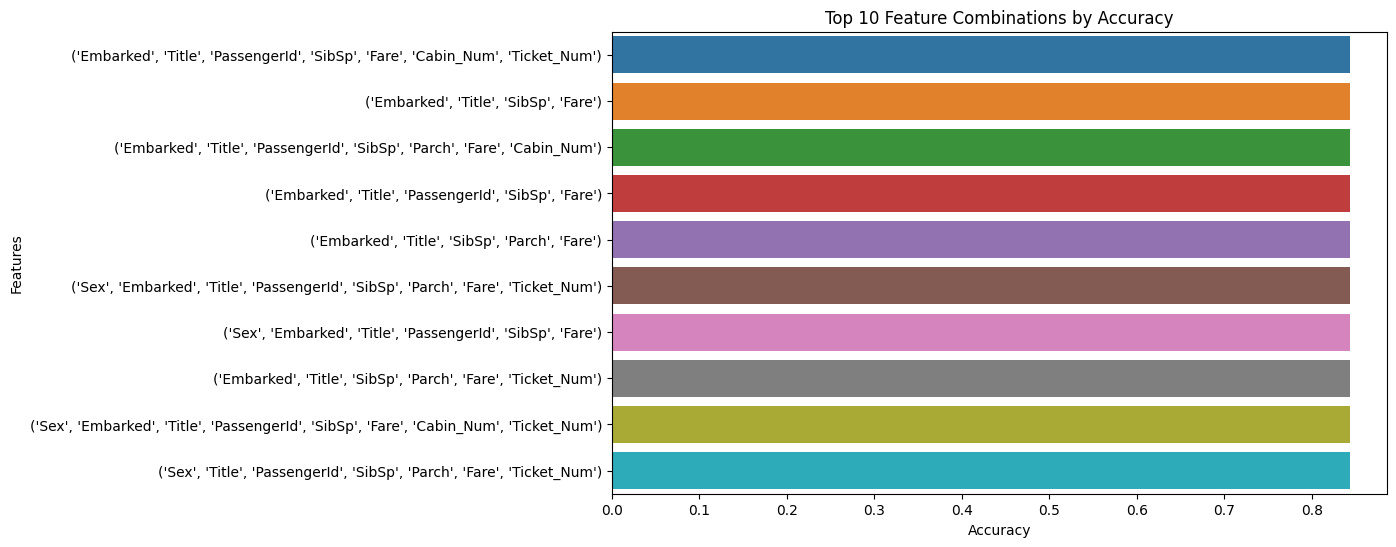

In [19]:
top_results = results_df.sort_values(by='Accuracy',ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy',y='Features',data=top_results)
plt.title('Top 10 Feature Combinations by Accuracy')

In [20]:
categorical_features = ['Embarked','Title','Sex']
numerical_features = ['Fare','Pclass']

<Axes: >

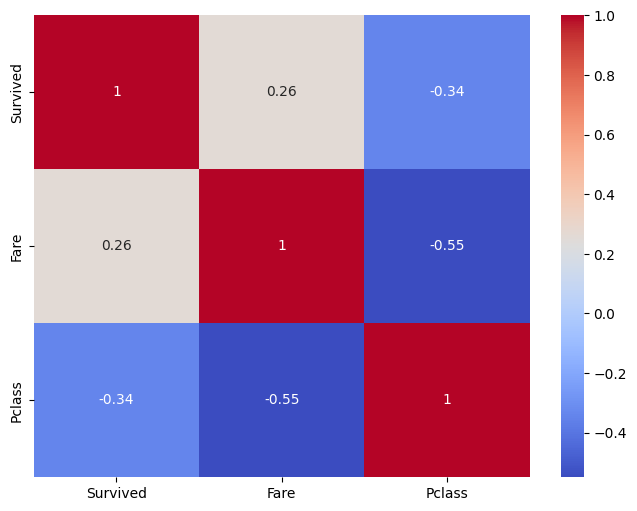

In [21]:
# Determine any possible relationships with numerical features
## Copy the dataset so the original is not affected
data = titanic_clean

## Correlation matrix
corr_matrix = data[['Survived'] + numerical_features].corr()

## Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')

In [22]:
# Determine any possible relationships with numerical features
## Copy the dataset so the original is not affected
data = titanic_clean

# Iterate through the features and do the chi-square test
for col in categorical_features:
    contingency_table = pd.crosstab(data[col],data['Survived'])
    chi2,p,dof,expected = chi2_contingency(contingency_table)

    # Print the test scores
    print(f'Chi-square test for {col}:')
    print(f'Chi2: {chi2:.4f}, p-value: {p:.4f}\n')

Chi-square test for Embarked:
Chi2: 26.4891, p-value: 0.0000

Chi-square test for Title:
Chi2: 288.1183, p-value: 0.0000

Chi-square test for Sex:
Chi2: 260.7170, p-value: 0.0000



In [23]:
# Create a dictionary of both numeric and categorical categories to continue with
features = {}
features.update({
    'categorical':categorical_features,
    'numerical':numerical_features
})

## 1. Initial Modeling & Hyperparameters

### 1.1 Creating a data pipeline & making initial validations

In [24]:
# initialize the validation dictionary
metric_valid_dict = {}

In [25]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings

In [26]:
# Function to take the true and predicted values and provide scoring
def evaluate_preds(true,preds):
    """
    Performs evalution comparisons on y_true values vs. y_pred values on a classification.
    """
    
    # create a dictionary of scoring values
    metric_dict = {
        'accuracy':round(accuracy_score(true,preds),2),
        'precision':round(precision_score(true,preds),2),
        'recall':round(recall_score(true,preds),2),
        'f1':round(f1_score(true,preds),2)
    }
    
    # print the calculated metrics
    for item in metric_dict:
        if item == 'accuracy':
            print(f'{item}: {metric_dict[item]*100:.2f}%')
        else:
            print(f'{item}: {metric_dict[item]:.2f}')
    
    return metric_dict

In [27]:
# Split the data into train and validation sets
X = titanic_clean.drop('Survived',axis=1)
y = titanic_clean['Survived']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((712, 18), (712,), (179, 18), (179,))

In [28]:
# Make the preprocesser for use specifically with sklearn ensembles
preprocessor = ColumnTransformer(
    transformers=[
        ('num',Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='median')),
            ('scaler',StandardScaler())
        ]),features['numerical']),
        ('cat',Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='most_frequent')),
            ('onehot',OneHotEncoder(handle_unknown='ignore'))
        ]),features['categorical'])
    ])

# Make the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',GradientBoostingClassifier(random_state=42))
])

# Fit the data
pipeline.fit(X_train,y_train)

# Make a prediction
y_pred = pipeline.predict(X_valid)

In [29]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(pipeline,X_train,y_train,cv=skf,scoring='accuracy')
print(f'Cross-validation accuracy: {scores.mean()}')

Cross-validation accuracy: 0.8371023342854329


In [30]:
# Create metrics for model and add metrics to metrics dictionary
metric_valid_dict.update({'RandomForestClassifier baseline':evaluate_preds(y_valid,y_pred)})

accuracy: 81.00%
precision: 0.77
recall: 0.72
f1: 0.75


In [31]:
warnings.simplefilter(action='ignore',category=FutureWarning)

param_dist = {
    'classifier__n_estimators':randint(50,300),
    'classifier__learning_rate':uniform(0.01,0.3),
    'classifier__max_depth':randint(3,10),
    'classifier__min_samples_split':randint(2,10),
    'classifier__min_samples_leaf':randint(1,10),
    'classifier__subsample':uniform(0.8,0.2),
    'classifier__max_features':['sqrt','log2']
}

random_search = RandomizedSearchCV(pipeline,param_distributions=param_dist,
                                  n_iter=100,cv=5,scoring='accuracy',n_jobs=-1,random_state=42,verbose=0)

random_search.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Fare',
                                                                                'Pclass']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Embark...
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d5ad7ed98d0>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d5ad7df4df0>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d5ad7ed9660>},
                   random_state=42, scoring='accuracy')

In [32]:
y_preds_rs = random_search.predict(X_valid)

metric_valid_dict.update({'RandomSearchCV':evaluate_preds(y_valid,y_preds_rs)})

accuracy: 80.00%
precision: 0.76
recall: 0.72
f1: 0.74


In [33]:
warnings.simplefilter(action='ignore',category=FutureWarning)

param_grid = {
    'classifier__n_estimators':[100,200],
    'classifier__learning_rate':[0.01,0.1],
    'classifier__max_depth':[3,5,7],
    'classifier__min_samples_split':[2,5],
    'classifier__min_samples_leaf':[1,2],
    'classifier__subsample':[0.8,1.0],
    'classifier__max_features':['sqrt']
}

grid_search = GridSearchCV(pipeline,param_grid,cv=5,scoring='accuracy',verbose=0)
grid_search.fit(X_train,y_train)

y_pred_gs = grid_search.predict(X_valid)

metric_valid_dict.update({'GridSearchCV':evaluate_preds(y_valid,y_pred_gs)})

accuracy: 81.00%
precision: 0.79
recall: 0.70
f1: 0.74


In [34]:
# Function with fiddly knobs that can be used to generate a tensorflow model and make improvements overtime
def build_model(
    input_shape,num_layers=2,units_per_layer=[128,64],
    activation='relu',dropout_rate=0.5,
    regularization=None,learning_rate=0.001):
    
    # Initialize the model
    model = models.Sequential()
    
    # Generate the input layer
    model.add(layers.Dense(units_per_layer[0],activation=activation,
                           input_shape=(input_shape,),
                           kernel_regularizer=regularizers.l2(regularization) if regularization else None))
    
    # Optional dropout after the first layer
    if dropout_rate:
        model.add(layers.Dropout(dropout_rate))
    
    # Add hidden layers dynamically based on the num_layers and units_per_layer
    for i in range(1,num_layers):
        model.add(layers.Dense(units_per_layer[i],activation=activation,
                               kernel_regularizer=regularizers.l2(regularization) if regularization else None))
        if dropout_rate:
            model.add(layers.Dropout(dropout_rate))
    
    # Output Layer (binary classification with sigmoid)
    model.add(layers.Dense(1,activation='sigmoid'))
    
    # Compile the model with the provided learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',metrics=['accuracy','precision','recall'])
    
    return model

In [35]:
# Create the preprocessor using OneHotEncoder and ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(handle_unknown='ignore'),features['categorical']),
        ('num',Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='mean')),
            ('scaler',StandardScaler())
        ]),features['numerical']),
        ('ticket',ticket_pipeline,'Ticket_ABC') # pipeline specifically for Ticket_ABC column
    ])

# Fit the preprocessor to all the cleaned data
preprocessor.fit_transform(titanic_clean)

# Transform X_train and X_test on the fit transformation
X_train_preprocessed = preprocessor.transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

# Check the shapes
X_train_preprocessed.shape,X_valid_preprocessed.shape

((712, 14), (179, 14))

## 2. Hypertuning & Metric Scoring

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729617747.555074      71 service.cc:145] XLA service 0x7d5a4000c3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729617747.555127      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729617747.555131      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729617751.097832      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


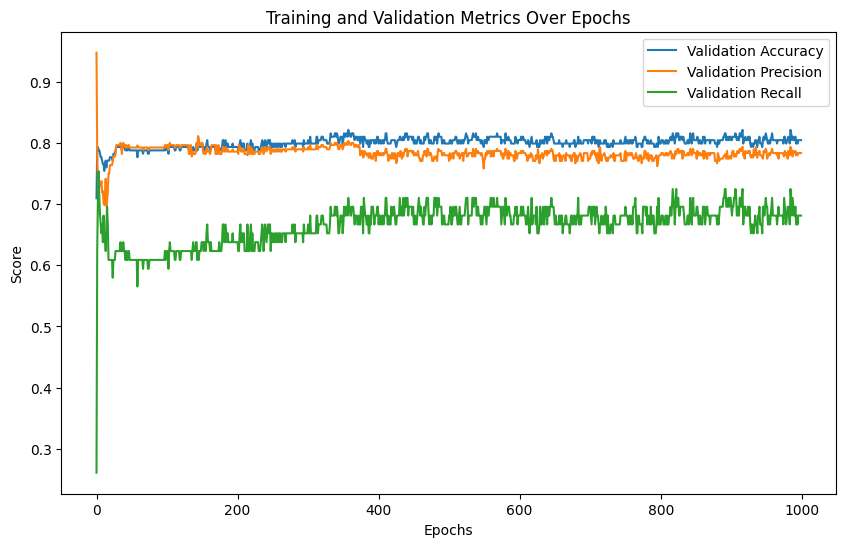

In [36]:
# Generate the model
model = build_model(
    input_shape=X_train_preprocessed.shape[1],
    learning_rate=0.001
)

# Fit the model
history = model.fit(X_train_preprocessed,y_train,epochs=1000,batch_size=32,validation_data=(X_valid_preprocessed,y_valid),verbose=0)

# Plot the metrics over epoch
plt.figure(figsize=(10,6))

# Accuracy
#plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')

# Precision
#plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'],label='Validation Precision')

# Recall
#plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'],label='Validation Recall')

# Overall customizations
plt.title('Training and Validation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend(loc='best')

# Show results
plt.show()

In [37]:
# Evaluate the model
_,test_acc,_,_ = model.evaluate(X_valid_preprocessed,y_valid)

# Spit out the results
print(f'Test Accuracy: {test_acc * 100:.2f}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.5654 - precision: 0.7695 - recall: 0.6304 
Test Accuracy: 80.45%


In [38]:
# Create a prediction and convert it into values similar to SciKit-Learn
y_preds = model.predict(X_valid_preprocessed)
y_preds = (y_preds > 0.5).astype("int32")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [39]:
y_preds.shape,y_valid.shape

((179, 1), (179,))

In [40]:
# Evaluate and score the model
metric_valid_dict.update({'tensorflow baseline':evaluate_preds(y_valid,y_preds)})

accuracy: 80.00%
precision: 0.78
recall: 0.68
f1: 0.73


### 2.1 Final Predictions

In [41]:
from sklearn.model_selection import KFold

In [42]:
# Turn this into a function
def hypertune_model(
    model,
    X_train_preprocessed,
    X_valid_preprocessed,
    y_train,
    y_valid,
    epochs = 10
):

    # Initialize values
    best_model = None
    best_accuracy = 0
    kfold = KFold(n_splits=5,shuffle=True)
    input_shape = X_train_preprocessed.shape[1]

    '''
    # Initialize values
    best_model = None
    best_accuracy = 0
    kfold = KFold(n_splits=5,shuffle=True)
    input_shape = X_train_preprocessed.shape[1]
    '''
    
    # Create embedded for loops with the metrics to fiddle with
    for units in [[128,64],[256,128,64],[512,256,128]]:
        for dropout in [0.3, 0.5]:
            for lr in [0.001,0.0005]:
                for batch_size in [32,64]:
                    model = build_model(input_shape=input_shape,
                                       num_layers=len(units),
                                                 units_per_layer=units,
                                                 dropout_rate=dropout,
                                                 learning_rate=lr)
                    
                    # Train the model with the current hyperparameters
                    history = model.fit(X_train_preprocessed,y_train,epochs=epochs,batch_size=batch_size,
                                       validation_data=(X_valid_preprocessed,y_valid),verbose=0)
                    
                    # Evaluate validation accuracy
                    val_acc = history.history['val_accuracy'][-1]
                    
                    # Keep track of the best model
                    if val_acc > best_accuracy:
                        best_accuracy = val_acc
                        best_model = model

    # Return the best_accuracy model
    return best_model,best_accuracy

In [43]:
best_model,best_accuracy = hypertune_model(model,X_train_preprocessed,X_valid_preprocessed,y_train,y_valid,epochs=600)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
print(f'{best_accuracy*100:.2f}%')

82.12%


In [45]:
predictions_test = best_model.predict(X_valid_preprocessed)
predictions_to_binary = (predictions_test > 0.5).astype('int32')
metric_valid_dict.update({'tensorflow best':evaluate_preds(y_valid,predictions_to_binary)})

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
accuracy: 82.00%
precision: 0.80
recall: 0.71
f1: 0.75


<Axes: >

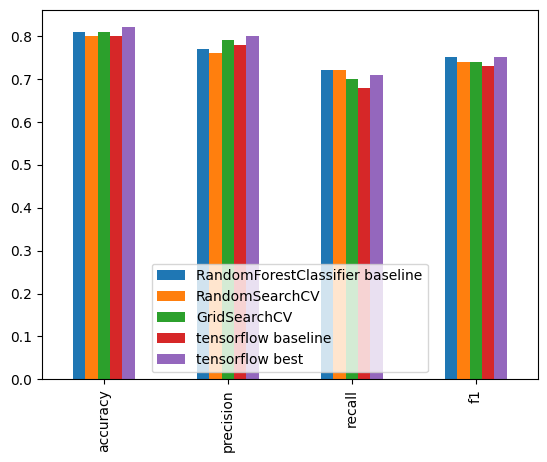

In [46]:
pd.DataFrame(metric_valid_dict).plot.bar()

## 3. Predict Survivors & Make Submission

In [47]:
# Read the test data
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Clean, Process, and Make predicitions using generated model
Predictions = best_model.predict(preprocessor.transform(clean_df(test_data)))
Predictions_binary = (Predictions > 0.5).astype('int32')

#Predictions_binary = pipeline.predict(clean_df(test_data))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [48]:
# Build the submission dataframe
submission = pd.DataFrame({
    'PassengerId':test_data['PassengerId'],
    'Survived':Predictions_binary.flatten()
})

In [49]:
submission.to_csv('submission.csv',index=False)